****A Hybrid LSTM-PPO Framework for High-Accuracy Options Trading Based on Technical Setups in the Indian Market****


**Build a smart AI system that takes any technical strategy (like gap-up, trap candle, impulsive), and uses LSTM to classify the signal’s strength and PPO/DQN to decide whether to trade CE, PE, or skip — all based on PnL reward and market context.**

Install Required Dependancies

In [16]:
!pip3 install smartapi-python --upgrade stable-baselines3
!pip3 install pandas_ta


!pip3 install stable-baselines3
!pip3 install shimmy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [17]:
from SmartApi import SmartConnect
import pyotp
import http.client
import json
from datetime import datetime, timedelta
import pandas as pd
import socket
import requests
import uuid
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler

In [18]:
def Login_To_Angleone():
    api_key = "WUCyfVgK" # Using the first API Key
    smartAPI = SmartConnect(api_key)
    try:

        totp = pyotp.TOTP("2AMWG2Z2FZ3ZOFBJATC7EFDWFY").now()
        data = smartAPI.generateSession("N274681", "6499", totp)
        if not data['status']:
            return None

        jwtToken = data['data']['jwtToken']
        refreshToken = data['data']['refreshToken']
        feedToken = data['data']['feedToken']
        return jwtToken, refreshToken, feedToken, smartAPI
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
jwtToken, refreshToken, feedToken, smartAPI = Login_To_Angleone()

In [19]:
def Get_IP_Info():
    s = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM)

    local_IP =  "127.0.0.1"
    Public_IP = requests.get("https://api.ipify.org").text

    try:
        s.connect(("10.254.254.254",1)) # We use 10.254.254.254 to trick system to get local IP
        local_IP = s.getsockname()[0]
    finally:
        s.close()
    return local_IP, Public_IP,':'.join(['{:02x}'.format((uuid.getnode() >> elements) & 0xff) for elements in range(0, 2*6, 2)][::-1])

In [20]:
from time import sleep


def fetch_5_years_5min_candle(authToken, index):
    

    # Get stock token
    Stock_Token = "99926000" # For Nifty

    conn = http.client.HTTPSConnection("apiconnect.angelbroking.com")
    local_IP, public_IP, mac_address = Get_IP_Info()
    apikey = "WUCyfVgK"

    # Define time range
    end_date = datetime.now().replace(second=0, microsecond=0)
    start_date = end_date - timedelta(days=365 * 5)  # 5 years ago

    all_candles = []

    while start_date < end_date:
        batch_end = min(start_date + timedelta(days=30), end_date)

        payload = json.dumps({
            "exchange": "NSE",
            "symboltoken": Stock_Token,
            "interval": "FIVE_MINUTE",
            "fromdate": start_date.strftime("%Y-%m-%d %H:%M"),
            "todate": batch_end.strftime("%Y-%m-%d %H:%M")
        })

        headers = {
            'X-PrivateKey': apikey,
            'Authorization': authToken,
            'X-SourceID': 'WEB',
            'X-ClientLocalIP': local_IP,
            'X-ClientPublicIP': public_IP,
            'X-MACAddress': mac_address,
            'X-UserType': 'USER',
            'Accept': 'application/json',
            'Content-Type': 'application/json'
        }

        try:
            conn.request("POST", "/rest/secure/angelbroking/historical/v1/getCandleData", payload, headers)
            res = conn.getresponse()
            data = res.read().decode("utf-8")
            response_json = json.loads(data)
        except Exception as e:
            print(f"Request failed from {start_date} to {batch_end}: {e}")
            break

        if 'data' in response_json and response_json['data']:
            all_candles.extend(response_json['data'])
            print(f"✅ Fetched: {start_date.strftime('%Y-%m-%d')} to {batch_end.strftime('%Y-%m-%d')} - Candles: {len(response_json['data'])}")
        else:
            print(f"⚠️ No data for {start_date.strftime('%Y-%m-%d')} to {batch_end.strftime('%Y-%m-%d')}")

        # Move to next batch
        start_date = batch_end
        sleep(1.2)  # avoid rate limiting (optional, adjust as needed)

    conn.close()

    if not all_candles:
        return None

    # Convert to DataFrame
    df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

In [51]:
df = fetch_5_years_5min_candle(jwtToken, "NIFTY")

✅ Fetched: 2020-04-19 to 2020-05-19 - Candles: 1575
✅ Fetched: 2020-05-19 to 2020-06-18 - Candles: 1575
✅ Fetched: 2020-06-18 to 2020-07-18 - Candles: 1575
✅ Fetched: 2020-07-18 to 2020-08-17 - Candles: 1575
✅ Fetched: 2020-08-17 to 2020-09-16 - Candles: 1650
✅ Fetched: 2020-09-16 to 2020-10-16 - Candles: 1575
✅ Fetched: 2020-10-16 to 2020-11-15 - Candles: 1514
✅ Fetched: 2020-11-15 to 2020-12-15 - Candles: 1500
✅ Fetched: 2020-12-15 to 2021-01-14 - Candles: 1575
✅ Fetched: 2021-01-14 to 2021-02-13 - Candles: 1500
✅ Fetched: 2021-02-13 to 2021-03-15 - Candles: 1451
✅ Fetched: 2021-03-15 to 2021-04-14 - Candles: 1425
✅ Fetched: 2021-04-14 to 2021-05-14 - Candles: 1500
✅ Fetched: 2021-05-14 to 2021-06-13 - Candles: 1500
✅ Fetched: 2021-06-13 to 2021-07-13 - Candles: 1650
✅ Fetched: 2021-07-13 to 2021-08-12 - Candles: 1575
✅ Fetched: 2021-08-12 to 2021-09-11 - Candles: 1425
✅ Fetched: 2021-09-11 to 2021-10-11 - Candles: 1575
✅ Fetched: 2021-10-11 to 2021-11-10 - Candles: 1438
✅ Fetched: 2

In [52]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.index = df.index.tz_localize(None)
df.head(-1)

,open,high,low,close,volume
timestamp,,,,,
2020-04-20 09:15:00,9390.20,9390.85,9269.55,9291.95,0.0
2020-04-20 09:20:00,9293.90,9322.30,9265.85,9319.20,0.0
2020-04-20 09:25:00,9319.45,9352.90,9313.55,9331.80,0.0
2020-04-20 09:30:00,9330.05,9339.95,9289.45,9296.75,0.0
2020-04-20 09:35:00,9296.00,9296.00,9244.00,9247.75,0.0
...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0


In [53]:
import pandas_ta as ta

def add_all_indicators(df):
    # Trend Indicators
    df['ema_20'] = ta.ema(df['close'], length=20)
    df['ema_50'] = ta.ema(df['close'], length=50)
    df['ema_200'] = ta.ema(df['close'], length=200)
    df['sma_20'] = ta.sma(df['close'], length=20)
    df['sma_50'] = ta.sma(df['close'], length=50)

    # Momentum Indicators
    df['rsi_14'] = ta.rsi(df['close'], length=14)
    df['macd'] = ta.macd(df['close'])['MACD_12_26_9']
    df['macd_signal'] = ta.macd(df['close'])['MACDs_12_26_9']
    df['stoch_k'] = ta.stoch(df['high'], df['low'], df['close'])['STOCHk_14_3_3']
    df['stoch_d'] = ta.stoch(df['high'], df['low'], df['close'])['STOCHd_14_3_3']
    df['cci'] = ta.cci(df['high'], df['low'], df['close'], length=20)

    # Volatility Indicators
    bb = ta.bbands(df['close'], length=20)
    df['bb_upper'] = bb['BBU_20_2.0']
    df['bb_middle'] = bb['BBM_20_2.0']
    df['bb_lower'] = bb['BBL_20_2.0']
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=14)

    # Volume-Based Indicators

    # Trend Strength
    df['adx'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']
    
    return df


In [54]:
df = add_all_indicators(df)

In [55]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-20 09:15:00,9390.20,9390.85,9269.55,9291.95,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 09:20:00,9293.90,9322.30,9265.85,9319.20,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 09:25:00,9319.45,9352.90,9313.55,9331.80,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 09:30:00,9330.05,9339.95,9289.45,9296.75,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 09:35:00,9296.00,9296.00,9244.00,9247.75,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,41.270764,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,38.752961,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,35.848097,44.852924,76.999812,80.322763,32.028896,23876.000575,23843.9750,23811.949425,23.323651,38.152491


In [56]:
df.dropna(inplace=True)


In [57]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-22 13:20:00,9138.95,9162.65,9135.35,9157.10,0.0,9123.054463,9083.016120,9117.007750,9123.0725,9068.762,...,21.979200,22.306898,73.203492,73.931197,119.756787,9161.259821,9123.0725,9084.885179,20.453310,34.769252
2020-04-22 13:25:00,9157.20,9159.40,9124.70,9125.70,0.0,9123.306419,9084.689997,9117.094240,9123.9175,9070.697,...,19.567379,21.758994,62.410050,68.519469,53.615960,9161.548010,9123.9175,9086.286990,21.470931,34.078482
2020-04-22 13:30:00,9125.80,9126.35,9109.60,9118.00,0.0,9122.801046,9085.996272,9117.103253,9124.8325,9072.937,...,16.840540,20.775303,49.927893,61.847145,-29.641543,9160.921449,9124.8325,9088.743551,21.133722,32.427778
2020-04-22 13:35:00,9118.70,9130.55,9099.50,9107.75,0.0,9121.367613,9086.849359,9117.010185,9125.5225,9075.509,...,13.694550,19.359153,24.830422,45.722788,-61.221198,9159.700336,9125.5225,9091.344664,21.842028,30.298611
2020-04-22 13:40:00,9107.60,9117.00,9089.55,9108.95,0.0,9120.184983,9087.716051,9116.929985,9125.8075,9077.751,...,11.169405,17.721203,20.521393,31.759903,-100.285224,9159.326394,9125.8075,9092.288606,22.242597,28.489168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,41.270764,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,38.752961,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,35.848097,44.852924,76.999812,80.322763,32.028896,23876.000575,23843.9750,23811.949425,23.323651,38.152491


In [58]:
def label_trades_first_hit(df, target_move=80, lookahead=5):
    """
    Labels each candle in the dataframe based on whether the price
    moves up or down by a target amount within a lookahead window.
    
    Parameters:
        df (pd.DataFrame): DataFrame with a 'close' column
        target_move (float): The number of points price must move to trigger a label
        lookahead (int): Number of future candles to look ahead

    Returns:
        df (pd.DataFrame): Same dataframe with an added 'label' column
                          1 = Buy CE, 2 = Buy PE, 0 = No Trade
    """
    labels = []
    close_prices = df['close'].values

    for i in range(len(df) - lookahead):
        entry_price = close_prices[i]
        label = 0  # Default: No Trade

        for j in range(1, lookahead + 1):
            future_price = close_prices[i + j]

            # Check for Buy CE
            if future_price - entry_price >= target_move:
                label = 1
                break

            # Check for Buy PE
            elif entry_price - future_price >= target_move:
                label = 2
                break

        labels.append(label)

    # Pad the end with 0s (no label for incomplete future data)
    labels += [0] * lookahead
    df['label'] = labels

    return df


In [59]:
df = label_trades_first_hit(df, target_move=80, lookahead=5)


In [60]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-22 13:20:00,9138.95,9162.65,9135.35,9157.10,0.0,9123.054463,9083.016120,9117.007750,9123.0725,9068.762,...,22.306898,73.203492,73.931197,119.756787,9161.259821,9123.0725,9084.885179,20.453310,34.769252,0
2020-04-22 13:25:00,9157.20,9159.40,9124.70,9125.70,0.0,9123.306419,9084.689997,9117.094240,9123.9175,9070.697,...,21.758994,62.410050,68.519469,53.615960,9161.548010,9123.9175,9086.286990,21.470931,34.078482,0
2020-04-22 13:30:00,9125.80,9126.35,9109.60,9118.00,0.0,9122.801046,9085.996272,9117.103253,9124.8325,9072.937,...,20.775303,49.927893,61.847145,-29.641543,9160.921449,9124.8325,9088.743551,21.133722,32.427778,0
2020-04-22 13:35:00,9118.70,9130.55,9099.50,9107.75,0.0,9121.367613,9086.849359,9117.010185,9125.5225,9075.509,...,19.359153,24.830422,45.722788,-61.221198,9159.700336,9125.5225,9091.344664,21.842028,30.298611,0
2020-04-22 13:40:00,9107.60,9117.00,9089.55,9108.95,0.0,9120.184983,9087.716051,9116.929985,9125.8075,9077.751,...,17.721203,20.521393,31.759903,-100.285224,9159.326394,9125.8075,9092.288606,22.242597,28.489168,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924,0
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734,0
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,44.852924,76.999812,80.322763,32.028896,23876.000575,23843.9750,23811.949425,23.323651,38.152491,0


No Trade (Label 0): 87086
Buy CE (Label 1): 2825
Buy PE (Label 2): 2649


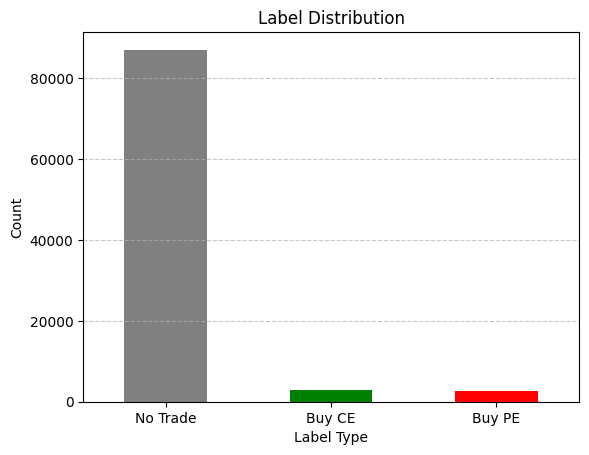

In [62]:
label_counts = df['label'].value_counts().sort_index()

# Print nicely
label_map = {0: 'No Trade', 1: 'Buy CE', 2: 'Buy PE'}
for label, count in label_counts.items():
    print(f"{label_map[label]} (Label {label}): {count}")

import matplotlib.pyplot as plt

label_counts.rename(index=label_map).plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Label Distribution')
plt.ylabel('Count')
plt.xlabel('Label Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


🔁 Phase-by-Phase LSTM Workflow in Jupyter

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, BatchNormalization,
                                     Bidirectional, Lambda, Flatten, Activation,
                                     RepeatVector, Permute, Multiply)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [70]:
features = [
    'close', 'open', 'high', 'low',
    'ema_200', 'rsi_14', 'macd', 'adx',
    'bb_upper', 'bb_lower', 'stoch_k', 'stoch_d'
]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [71]:
SEQ_LEN = 60
X, y = [], []

for i in range(SEQ_LEN, len(df)):
    X.append(df[features].iloc[i-SEQ_LEN:i].values)
    y.append(df['label'].iloc[i])  # ⬅️ using 'label' now

X = np.array(X)
y = np.array(y)


In [72]:
X_flat = X.reshape(X.shape[0], -1)
smote = BorderlineSMOTE(kind='borderline-2', random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)
X_res = X_res.reshape(-1, SEQ_LEN, len(features))


/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [78]:
# ✅ Attention Block (unchanged)
def attention_block_with_weights(inputs):
    attention_scores = Dense(1, activation='tanh')(inputs)
    attention_scores = Flatten()(attention_scores)
    attention_weights = Activation('softmax', name='attention_weights')(attention_scores)
    attention_weights = RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    context_vector = Multiply()([inputs, attention_weights])
    return context_vector, attention_weights



In [79]:
input_shape = (X_res.shape[1], X_res.shape[2])
inp = Input(shape=input_shape)

x = Bidirectional(LSTM(128, return_sequences=True))(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# ✅ Keep attention for visualization (but don’t output it)
x, att_weights = attention_block_with_weights(x)
x = Lambda(lambda x: K.sum(x, axis=1))(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# ✅ This model only outputs class predictions
model = Model(inputs=inp, outputs=output)

# Compile
model.compile(optimizer=Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 60, 256)   │    144,384 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 60, 128)   │    164,352 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 60, 1)     │        129 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 60)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 60)        │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 60)   │          0 │ attention_weight… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 60, 128)   │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 60, 128)   │          0 │ dropout_4[0][0],  │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        195 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 318,852 (1.22 MB)

 Trainable params: 318,084 (1.21 MB)

 Non-trainable params: 768 (3.00 KB)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_res)
class_weights = dict(enumerate(class_weights))


In [81]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_lstm_attention_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/60


2025-04-18 21:37:34.282159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3264/3264 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4247 - loss: 1.1026
Epoch 1: val_loss improved from inf to 0.88833, saving model to best_lstm_attention_model.keras
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 526s 160ms/step - accuracy: 0.4247 - loss: 1.1026 - val_accuracy: 0.5865 - val_loss: 0.8883 - learning_rate: 5.0000e-04
Epoch 2/60
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6366 - loss: 0.7951
Epoch 2: val_loss improved from 0.88833 to 0.64937, saving model to best_lstm_attention_model.keras
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 496s 152ms/step - accuracy: 0.6366 - loss: 0.7951 - val_accuracy: 0.7117 - val_loss: 0.6494 - learning_rate: 5.0000e-04
Epoch 3/60
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7515 - loss: 0.5944
Epoch 3: val_loss improved from 0.64937 to 0.46329, saving model to best_lstm_attention_model.keras
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 503s 154ms/step - accuracy: 0.7515 - loss: 0.5944 - val_accuracy: 0.8172 - val_loss: 0.4633 - learning_rate: 5.0

KeyboardInterrupt: 

In [82]:
att_model = Model(inputs=model.input, outputs=att_weights)
att_model.save("attention_visualizer_model.keras")


1632/1632 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step
Classification Report:
              precision    recall  f1-score   support

    No Trade       0.99      0.90      0.94     17231
      Buy CE       0.95      0.99      0.97     17504
      Buy PE       0.95      0.99      0.97     17481

    accuracy                           0.96     52216
   macro avg       0.96      0.96      0.96     52216
weighted avg       0.96      0.96      0.96     52216



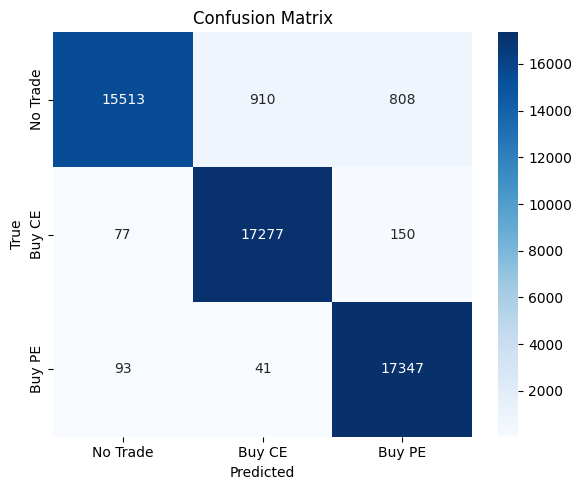

In [94]:
# Predict on validation set
y_pred_probs = model.predict(X_val)  # ✅ Only one output
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["No Trade", "Buy CE", "Buy PE"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Trade", "Buy CE", "Buy PE"],
            yticklabels=["No Trade", "Buy CE", "Buy PE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


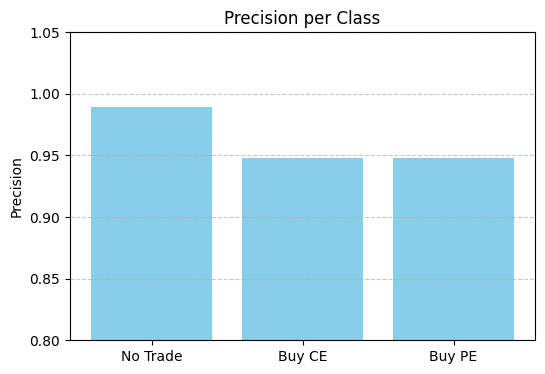

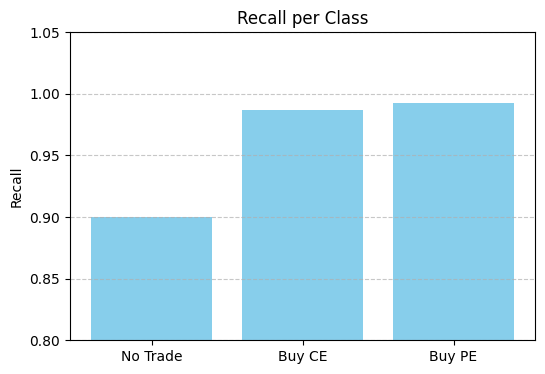

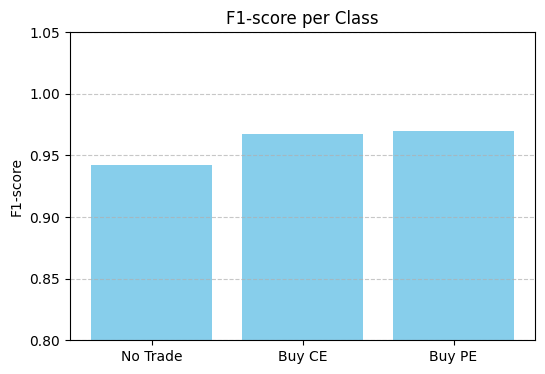

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred, target_names=["No Trade", "Buy CE", "Buy PE"], output_dict=True)

metrics = ["precision", "recall", "f1-score"]
classes = ["No Trade", "Buy CE", "Buy PE"]

for metric in metrics:
    plt.figure(figsize=(6,4))
    values = [report[c][metric] for c in classes]
    plt.bar(classes, values, color="skyblue")
    plt.ylim(0.8, 1.05)
    plt.title(f"{metric.capitalize()} per Class")
    plt.ylabel(metric.capitalize())
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


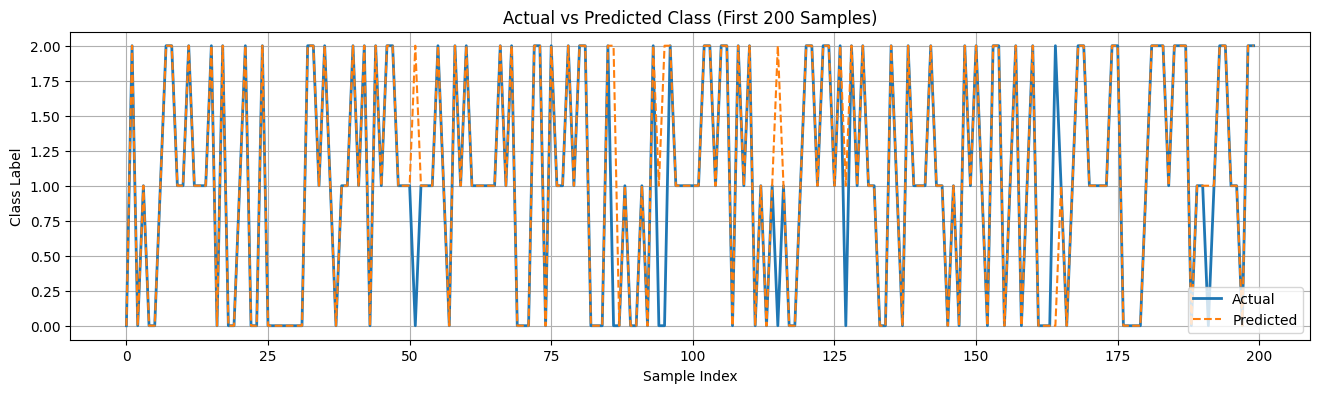

In [101]:
plt.figure(figsize=(16,4))
plt.plot(y_val[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Class (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid(True)
plt.show()


In [108]:
df.to_csv("ppo_ready_data.csv", index=False)

In [109]:
df_val = df.iloc[-len(X_val):].copy()
df_val['predicted_label'] = y_pred  # Optional: attach predictions if needed

df_val.to_csv("ppo_validation_data.csv", index=False)